# SLU14: Model Complexity and Overfitting

## Introduction

Welcome to SLU14, where we delve deeper into the intricate balance of model fitting. Building on the foundations of the bias-variance trade-off covered in the last unit, we'll explore the critical challenges of underfitting and overfitting in model training. Our focus will be on practical strategies to select and optimize models, leveraging the power of held-out test data and beyond.

This unit is designed to equip you with tools to fine-tune model complexity and combat overfitting, enhancing your model's predictive performance while maintaining generalizability. We'll navigate through the following key areas:

### 1. Feature Importance: The Bedrock of Model Performance

- [Why Bother About Features?](#Part-1:-Why-bother-about-features?): Understanding the pivotal role of features in model accuracy and complexity.
- [Techniques for Effective Feature Selection](#Part-2:-Feature-Selection): Mastering the art of choosing the right features.
  - General feature selection strategies: Techniques applicable across different models.
  - Model-specific feature selection methods: Tailoring feature selection to specific model architectures.

### 2. Regularization: Your Toolkit for Model Discipline

- [Harnessing Regularization](#Part-3:-Regularization): Learn how regularization techniques can prevent overfitting by introducing controlled model simplicity.

### 3. Tackling Unbalanced Data: A Path to Fairness and Accuracy

- [Addressing Data Imbalance](#Part-4:-Unbalanced-data): Strategies to handle unbalanced datasets, ensuring your model's robustness and fairness.

## What will you Learn

By the end of this unit, you will:

- Understand the significance of feature selection and how to implement it effectively.
- Be able to apply regularization techniques to reduce overfitting.
- Develop strategies to manage and model unbalanced datasets.

## Let's Begin!

Join us as we dive into the world of model complexity and overfitting, unlocking the secrets to more reliable and effective machine learning models!

In [1]:
# all imports at the top!
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from IPython.display import Image
import seaborn as sns 

from utils import (
    train_and_test, # function
    train_and_test_logit, # function
    produce_test_predictions, # function
    encode_categoricals, # function
    categoricals, # array of categorical feature names,
    read_and_get_dummies, # read the titanic dataframe and create dummies
    plot_classification, # plot classification datasets
)


-----

# Part 1: Why bother about features?

Let's say your boss gives you a dataset and tells you to do some analysis and a predictive model.

"Shall do!" you say, "I'll throw all of the features and data we have into a notebook, create a model, call `fit()`, and then we'll be good to deploy!"

This unfortunately happens in many companies leading to terrible mistakes. You will do better than this. 

Why is this story a bad example? Amongst other things, it leads to the following: 
1. Unexpected behavior
1. Overfitting (poor future performance)
1. Lack of interpretability
1. Unnecessary model complexity (that can also lead to long train/predict times)

The main thing to take from this notebook will be: don't throw data at a fancy model and hope for the best. 

Let's use the classic Titanic example to illustrate. 

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Let's be stupid. 

We are going to do everything wrong now. We'll just take ALL the features, and throw them into a classifier


We can use our functions from up top to do this quickly and easily
as well as produce a submission that we are actually going to upload to Kaggle. <mark>Remember, this is a section on what **NOT** to do, don't learn anything from it!</mark>

In [3]:
# If you want to see what these functions do just open a new cell and do <function>??
# but remember: these are BAD examples. 

# train a model with all features and keep track of the dummies so
# we know how to apply them (X_train)
X_train, train_df, clf = train_and_test()

# Now use the classifier to produce predictions
X_preds = produce_test_predictions(train_df, clf)

X_test accuracy 0.7541899441340782
X_train shape: (712, 2628)


Alright, so we turned our dataset into dummies, fit a decision tree classifier, made some predictions, and got some performance. We're flying blind, like incompetent data scientists. 

With a training dataframe that looks like this:

In [4]:
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,PassengerId_1,PassengerId_2,PassengerId_3,PassengerId_4,PassengerId_5,...,Cabin_F4,Cabin_G6,Cabin_T,Cabin_null,Cabin_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_null,Embarked_nan
301,3,-1.0,2,0,23.2500,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
309,1,30.0,0,0,56.9292,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
516,2,34.0,0,0,10.5000,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


If we make a submission to Kaggle, we end up with the following accuracy score:

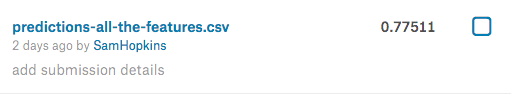

In [5]:
Image('media/all-features-kaggle-submission.png', width=800)

##### So... what's the problem then? 

You might be tempted to say "well, that's actually not a bad score". 

But let's think about this. We have a X_train (and thus a model) that has a huge number of features. We have a decision tree that goes many, many levels deep. 

**This is not ok.**

The reason why this is not ok isn't that obvious. Let's explore in more depth. 

For one thing, once we have created the dummies (as we should with categorical features) we ended up with way more features than observations. Imagine you are shown 100 examples of something and have to use 200 features. You simply don't have enough examples to know what features are relevant, which ones were just "coincidence". Exploding the number of features with a blind "get_dummies" puts us in a position where we have too many features for the number of observations. 

If you take this model to a responsible data scientist and claim that you are ready to put it into production, you will be laughed out of the room.


#### Should we use a feature just because you can?

Nop! Using a feature in your model just because you can has the potential to create all kinds of unknown scenarios, one of the worst is overfitting on uninformative features.

Let's zoom in on one part of this monster decision tree that we have created and take a look at the bottom-right leaf node that contains a prediction:

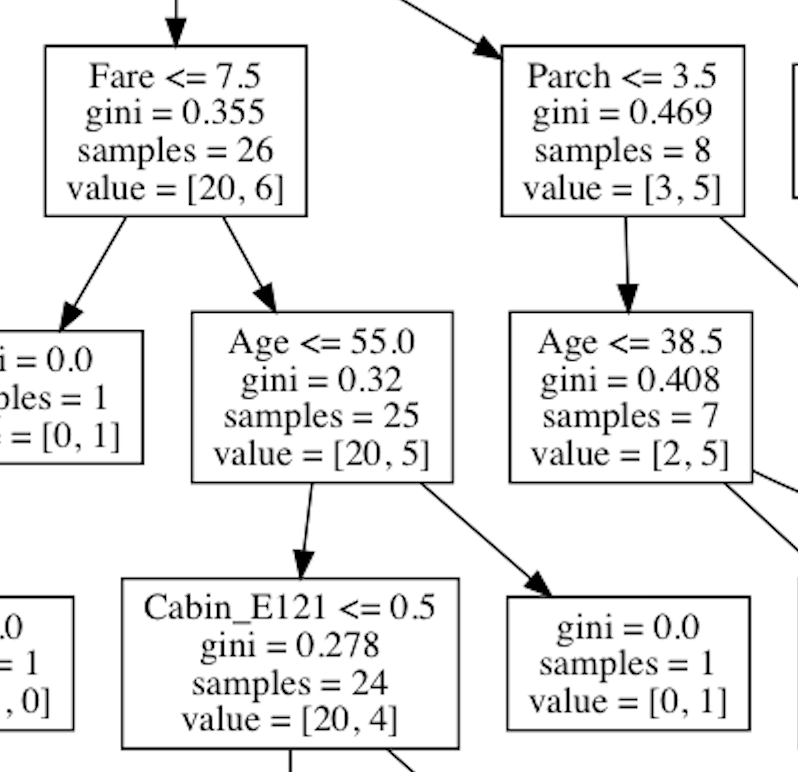

In [6]:
Image('media/overfit-zoom-in.png')

There is a split on the following conditions:

1. You are Male
1. Your Pclass is > 2.5
1. Your Fare is in between 7.5 and 16.4
1. Your age is between 19 and 55

Which corresponds to... <mark>one person!</mark>

This is a severely overfit model. There are things we could do about this (tuning the tree), but we made this very likely by having too many features. 

#### Let's use our excellent human brain! 

Let's think about these features for a bit. 

One good starting point is to look for categorical features that are unique for every observation. Logically, if every example has a different category, you can't learn anything from it, right? (unless you just want to memorize the training set). 

What are our categoricals? 

In [7]:
categoricals

['PassengerId', 'Name', 'Ticket', 'Sex', 'Cabin', 'Embarked']

Let's think of `Name` for instance. Without any further transformation, how could the "Name" feature be useful? It's just going to get turned into a dummy variable, one for each example: 

In [8]:
pd.get_dummies(df['Name']).head(3)

,"Abbing, Mr. Anthony","Abbott, Mr. Rossmore Edward","Abbott, Mrs. Stanton (Rosa Hunt)","Abelson, Mr. Samuel","Abelson, Mrs. Samuel (Hannah Wizosky)","Adahl, Mr. Mauritz Nils Martin","Adams, Mr. John","Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Aks, Mrs. Sam (Leah Rosen)","Albimona, Mr. Nassef Cassem",...,"Yrois, Miss. Henriette (""Mrs Harbeck"")","Zabour, Miss. Hileni","Zabour, Miss. Thamine","Zimmerman, Mr. Leo","de Messemaeker, Mrs. Guillaume Joseph (Emma)","de Mulder, Mr. Theodore","de Pelsmaeker, Mr. Alfons","del Carlo, Mr. Sebastiano","van Billiard, Mr. Austin Blyler","van Melkebeke, Mr. Philemon"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


But if we leave this in a model, we may find that it produces good metrics! Why? Because the model may simply say _"Oh yeah, that's Edward, I remember him."_

So as a rule of thumb, if there isn't a logical reason for using a feature, don't use it. It will do no good and can do damage. 

Let's look at our other categoricals, and use the `nunique` method to see how many unique examples they have:

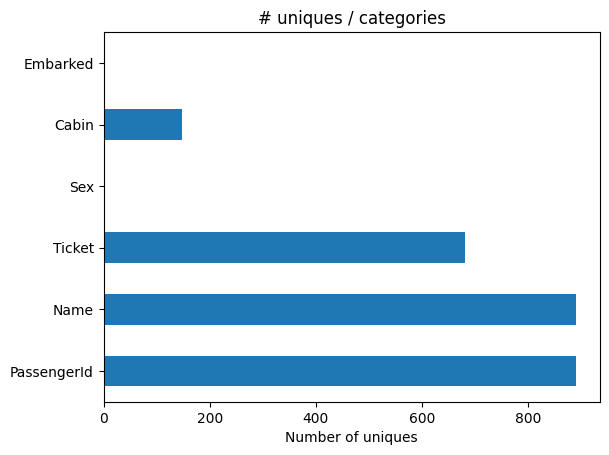

In [9]:
number_of_uniques_per_category = df.loc[:, categoricals].nunique()

# little plot 
number_of_uniques_per_category.plot(kind='barh',
                                    title='# uniques / categories');
plt.xlabel('Number of uniques')
plt.show()

We've already rejected `Name`, but what about the other ones? 


`PassengerId` seems to have the same issue as name. Generally datasets have a unique identifier for each example, which you will never want to feed to a model. 

Let's drop them and see how we do: 

In [10]:
drop_columns = [
    'PassengerId',
    'Name'
]
# notice that we are using a new parameter in train_and_test called
# drop_columns which does exactly what it's name suggests 
# (again, this is just custom code for this SLU, don't worry too much about it)

X_train, train_df, clf = train_and_test(drop_columns=drop_columns)
X_preds = produce_test_predictions(train_df, clf, drop_columns=drop_columns)
X_preds.to_csv('data/predictions-no-name-or-passid.csv', index=False)
train_df.shape

X_test accuracy 0.776536312849162
X_train shape: (712, 844)


(891, 10)

How did we do on our Kaggle challenge? 

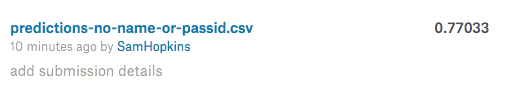

In [11]:
Image('media/no-name-passid-kaggle-submission.png', width=800)

Okay we are starting to move in the right direction now. Although still very complex, our tree is much less complex than it was before and our predictive power stayed the same (a decrease in 0.005 doesn't mean anything in the real world, only Kaggle). We still have 844 features though and if we revisit the chart that contained the number of uniques, we will be reminded why:

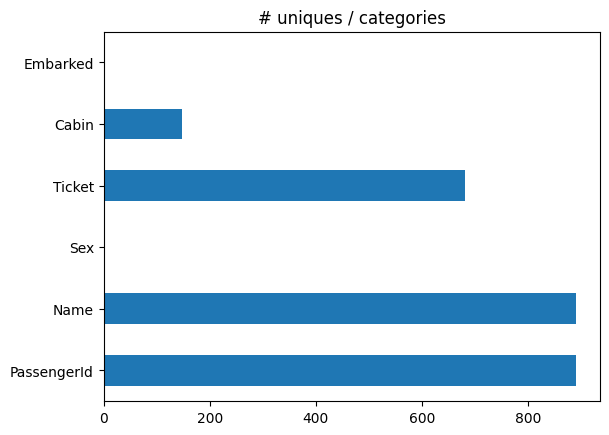

In [12]:
# Get all of the categorical that we have left and plot the number of uniques
# for each of them. It's essentially the same as before but a bit more compact.
cols = df.columns.intersection(categoricals)
df.loc[:, cols].nunique().plot(kind='barh',  title='# uniques / categories');

And if we zoom into our tree a bit more we can see where most of the splits are being done on the ticket number:

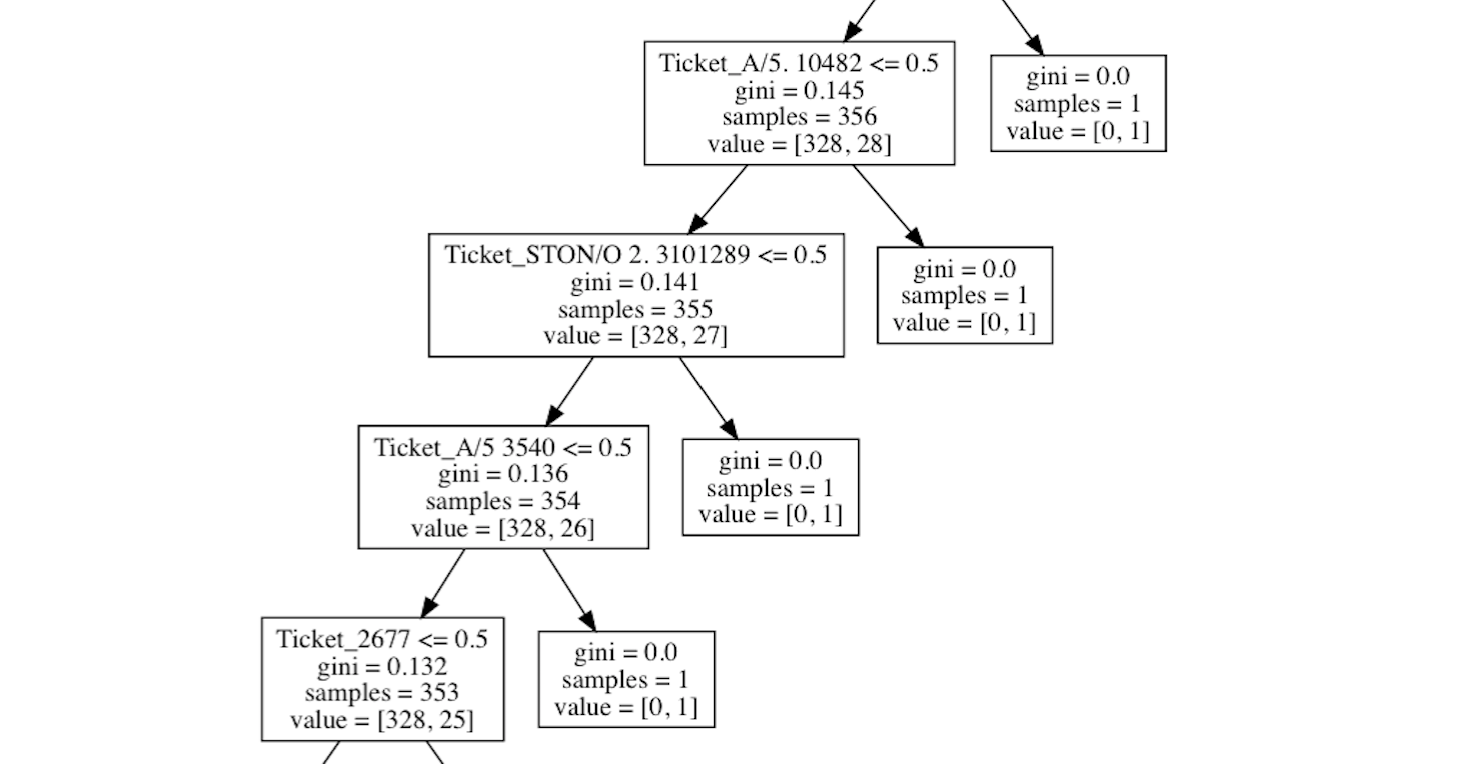

In [13]:
Image('media/no-name-passid-zoom-tree.png')

Ok, let's explore this `Ticket` feature a bit more. 

In [14]:
df.Ticket.head(3)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
Name: Ticket, dtype: object

Ok, so some text, followed by some numbers... Not very useful by itself.

Let's see how many times are tickets being reused. For this we need a **count of the count of tickets**.

In [15]:
df.Ticket.value_counts().value_counts()

count
1    547
2     94
3     21
4     11
7      3
6      3
5      2
Name: count, dtype: int64

Alright now it looks like we've got the majority of tickets being assigned to only one person. Maybe the other ones are families, hard to tell. 

As usual, when exploring it's good to look at examples. One of the tickets that show up more often is `CA. 2343`. Let's see if there is anything interesting about it: 

In [16]:
df.loc[df.Ticket == 'CA. 2343']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Ahah... so everyone is called Sage! They didn't survive, and were all in the same cabin, so it looks like a family. If you check other examples, they should be very similar (e.g. Ticket nr 347082 and 382652).

Alright, so we learned something interesting, which is that if two passengers are from the same Ticket, they tend to always survive or always die.  
_(ok in our example they all died but let's not over-think it)._

This may simply mean "families stick together". But now we have reached an interesting conclusion: if we split families into train and test set, any smart model will just look up whether they know someone from the same ticket, and check if they survived. 

This will look great on our training set AND on our test set. But when we try to make predictions outside in the real world, it's pretty useless. 

Remember: the fact that the test set validates things does not always mean it's a good idea. Common sense above all. 

_PS: the same probably applies to the "Cabin" feature but let's skip this for now_

----

# Part 2: Feature Selection 

So now you understand why it's worth going through a careful feature selection process. 

Some of the steps you've already seen: 
* Checking out categoricals with too many unique
* Rejecting features that don't make intuitive sense 

Now let's see some new approaches. They will break down into two categories: 
1. Model agnostic 
2. Model specific 

## Model agnostic feature selection 

Some feature selection does not depend on the model. For instance the stuff we've done already did not depend on which model we're using. But there are other things. 

Let's say for argument's sake that the dataset had a year of birth column: 

In [17]:
df['year of birth'] = (pd.to_datetime('May 31, 1911').year - df['Age'])

In [18]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,year of birth
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1889.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1873.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1885.0


We know intuitively that this feature should not contain any new information, as we already have the age. But models don't know this, and may "split the difference", and add complexity. If we hadn't detected this by looking at the feature names, how might we have detected it? 

### Spearman Correlation

One way may be to do a correlation matrix! It's generally not a bad idea to start with `spearman`, as it's more resistant to outliers, but you can use any.

In [19]:
corr_matrix = df.drop(categoricals, axis=1).corr(method='spearman')
corr_matrix

,Survived,Pclass,Age,SibSp,Parch,Fare,year of birth
Survived,1.000000,-0.339668,-0.052565,0.088879,0.138266,0.323736,0.052565
Pclass,-0.339668,1.000000,-0.361666,-0.043019,-0.022801,-0.688032,0.361666
Age,-0.052565,-0.361666,1.000000,-0.182061,-0.254212,0.135051,-1.000000
SibSp,0.088879,-0.043019,-0.182061,1.000000,0.450014,0.447113,0.182061
Parch,0.138266,-0.022801,-0.254212,0.450014,1.000000,0.410074,0.254212
Fare,0.323736,-0.688032,0.135051,0.447113,0.410074,1.000000,-0.135051
year of birth,0.052565,0.361666,-1.000000,0.182061,0.254212,-0.135051,1.000000


You'll notice that the spearman (rank) correlation between age and year of birth immediately stands out as -1!  

Remember when we made correlation matrices pretty in SLU05? Let's do that. 

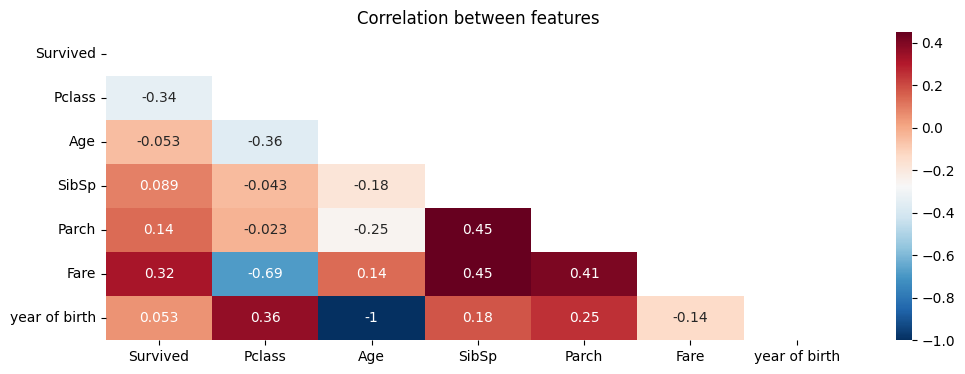

In [20]:
lower_triangle_mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
cor_mat_lower = corr_matrix.mask(lower_triangle_mask)

plt.figure(figsize = (12,4)) # <-- just sets the figure size 
plt.title("Correlation between features")

sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); #

Just by doing this we'd spot the problem, and get rid of the feature. (remember this only works for numericals) 

In [21]:
df = df.drop('year of birth', axis=1)

Now you may be thinking "what about correlation with target?"

Calculating correlation with target is useful, but it's only one way to do things. Let's do it now. 

In [22]:
df.drop(categoricals, axis=1).corr()['Survived'].sort_values()

Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

But correlation is a very linear thing, as you've studied before. We have better ways of making data talk. 

### Mutual info for classification

Mutual information is a fascinating concept, that is slightly outside of scope (if you want to know how it works [this video](https://www.youtube.com/watch?v=U9h1xkNELvY) explains it perfectly). In our case, we are just going to use it as a tool, for now. 

Think of Mutual information as measuring the reduction in uncertainty for predicting the outcome after we know a feature. 

In [23]:
# we'd normally import it at the top, but so that you know where it is 
from sklearn.feature_selection import mutual_info_classif

We can of course only use it for numeric features, so we'll exclude the categoricals 

In [24]:
numerical = df.drop(categoricals, axis=1).columns
numerical = numerical.drop('Survived')

In [25]:
mutual_info = mutual_info_classif(
    X=df[numerical].fillna(0),  # as with so much in sklearn, it does not like missing data
    y=df['Survived'])

In [26]:
numerical_mutual_info = pd.Series(mutual_info, index=numerical).sort_values()
numerical_mutual_info

SibSp     0.019126
Age       0.022293
Parch     0.045023
Pclass    0.060599
Fare      0.122120
dtype: float64

What about the categoricals? 

In [27]:
df[categoricals].nunique()

PassengerId    891
Name           891
Ticket         681
Sex              2
Cabin          147
Embarked         3
dtype: int64

We will reject `Name`, `PassengerId`, `Ticket` and `Cabin` as we suspect that it just represents families, and would not apply to an out of sample prediction. 

In [28]:
maybe_interesting = ['Sex', 'Embarked']

In [29]:
dummied_categs = pd.get_dummies(df[maybe_interesting])

In [30]:
mi = mutual_info_classif(X=dummied_categs, y=df['Survived'])

In [31]:
categorical_mutual_info = pd.Series(mi, index=dummied_categs.columns).sort_values()
categorical_mutual_info

Embarked_Q    0.000000
Embarked_S    0.009977
Embarked_C    0.031849
Sex_male      0.132824
Sex_female    0.154453
dtype: float64

Interesting, so the side where they boarded has very few information, but the sex seems to have a lot more information.

### Making decisions about features to drop 

This is always a bit more subjective. We may decide to keep a feature if we have a prior expectation that it makes "sense" that it should be predictive, and drop others. For instance in the case of numericals, we may want to keep age and drop "Parch" (whatever that is), as we may be interested in giving "Age" a chance. 

The thing to remember here is that your world model counts. The phrase "let the data speak for itself" is one of the greatest lies of the 21st century. Your big human brain has seen a lot more data than the one in the `.csv` file. 

In [32]:
display(numerical_mutual_info)
display(categorical_mutual_info)

SibSp     0.019126
Age       0.022293
Parch     0.045023
Pclass    0.060599
Fare      0.122120
dtype: float64

Embarked_Q    0.000000
Embarked_S    0.009977
Embarked_C    0.031849
Sex_male      0.132824
Sex_female    0.154453
dtype: float64

In [33]:
# here is my subjective decision 
features = [
    'Age', 
    'Pclass',
    'Fare',
    'Sex'
]

### Look at the tree 

This may sound like a model specific practice, but one easy way to get a "feel" for a dataset is to observe its tree. 

Fortunately, sklearn makes this really easy to do: 

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

We are going to fit a tree to the data we have considered acceptable, and see what it looks like

In [35]:
X = pd.get_dummies(df[features]).fillna(0)
y = df['Survived']

I will allow the tree to go down to 4 levels, but each leaf must have at least 5% of the dataset: 

In [36]:
dt = DecisionTreeClassifier(max_depth=2, 
                            min_samples_split=.05  # can also be number of samples
                           )
dt.fit(X, y);

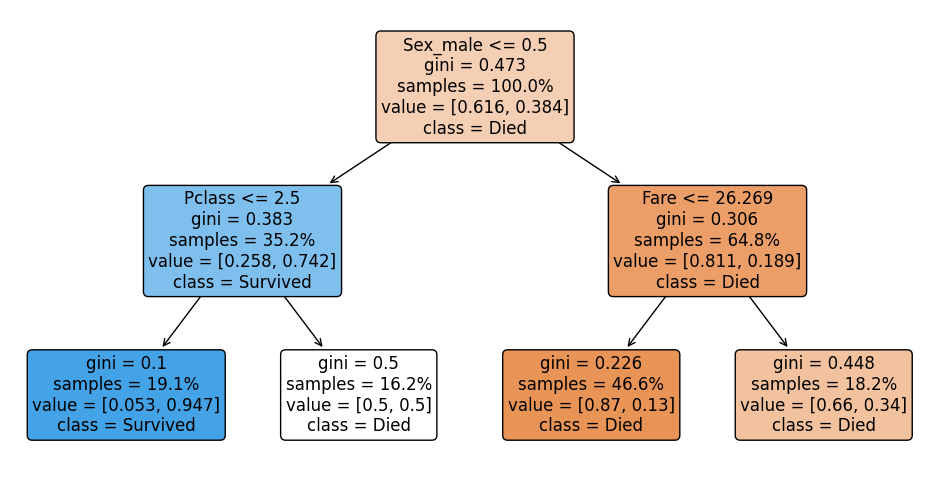

In [37]:
plt.subplots(figsize=(12, 6))  # this helps you control the figure size 

my_plot = plot_tree(
    decision_tree=dt,
    feature_names=list(X.columns),     # feature names to label the nodes 
    class_names=['Died', 'Survived'],  # what labels to place when the target is 0 or 1
    label='all',        
    filled=True,        # colors the squares 
    impurity=True,      
    proportion=True,    # show the fraction instead of number of examples  
    rounded=True,       # just cosmetic 
    fontsize=12);

That is a very interesting way to get to know the dataset! 

We can immediately see that the feature "Sex_male" is enough to break the data into 2 groups. The fare and Pclass also make for very good splits, and seem to separate "rich and poor". 

Try playing around with the tree depth and looking at different trees. It's generally a good idea to look at some trees, EVEN if you are going to use a non-tree based model. It's just a good match for how our brains think. 

Remember to keep enough samples in each node, to avoid nonsensical overfitting. 

-----

## Model specific feature selection

### How much does a model rely on a feature?

One type of feature selection is that of looking at how important a feature is to a model that you have already trained. This type of approach generally means that you are going to train a model with more features than you actually think you need and then look at the fitted models' attributes to see how much the model relied on it.

### `feature_importances_`

One really great way to do this is by using the [feature_importances_](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) of your classifier. This is a very useful attribute that you can use to understand how much the tree-based classifiers rely on each feature when making predictions.

Let's train a little Random Forest

In [38]:
rf = RandomForestClassifier()
rf.fit(X, y);

What was important for that random forest? 

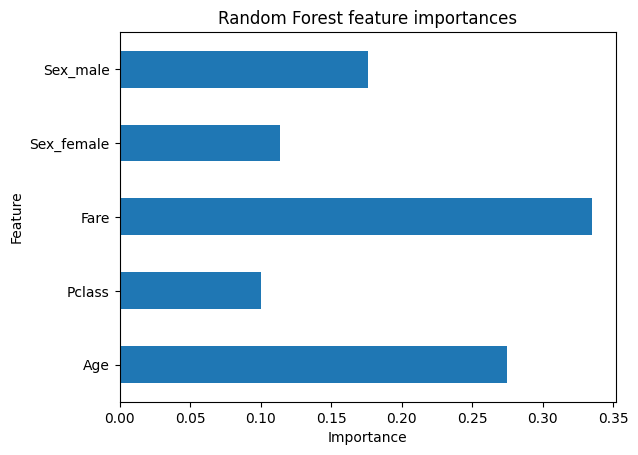

In [39]:
pd.Series(rf.feature_importances_, index=X.columns).plot.barh();
plt.title('Random Forest feature importances')
plt.xlabel('Importance');
plt.ylabel('Feature');

Interesting. The random forest actually finds `Age` and `Fare` really important. 

### `coef_` for linear models 

Somewhat analogous to the `feature_importances_` of a tree-based classifier is the coef_ attribute, that can be found on linear models. 

We will show an example of this with [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

As a reminder, with linear models we generally have the features scaled. If you don't scale your features your Logistic Regression will perform worse, and also the coefficients will be adjusted to the magnitude of your data. 

In this case, the coefficients are what you'd normally think of as the "betas" of the logistic regression. 

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [41]:
ss = StandardScaler()
X_normalized = ss.fit_transform(X)

lr = LogisticRegression()
lr.fit(X_normalized, y);

In [42]:
coefs = pd.Series(
    lr.coef_[0], # always the zeroth index. Awkward, I know. 
    index=X.columns   # X_normalized no longer has columns, so I'm using X
)
coefs 

Age          -0.269175
Pclass       -0.873219
Fare          0.059134
Sex_female    0.622825
Sex_male     -0.622825
dtype: float64

Barh plots are your friend. 

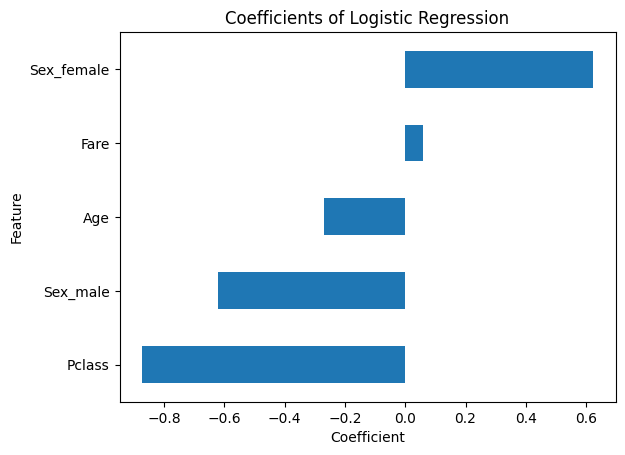

In [43]:
coefs.sort_values().plot(kind='barh');
plt.title('Coefficients of Logistic Regression')
plt.xlabel('Coefficient');
plt.ylabel('Feature');

So we can see that the logistic regression cares a lot about Sex_female, and (unlike in the Random Forest case) we can see the direction: it thinks it goes in the direction of survival. 

On the other hand, it does not have much use for "Fare", so we would probably drop that feature if we were going with a linear model. 

# Part 3: Regularization 

So you've seen how reducing the number of features can help with keeping the complexity of your model in check, and ultimately avoid overfitting. But what happens if even so your features are noisy, or you just have a small poll of very sparse data? If we reduce too much the number of features we might just end up with a very very simplistic model. And underfitting is also not what we want! 

We'll introduce a topic that can be used to handle these situations, and focus in particular on linear models applied to regression tasks, as opposed to classification. However, you should be familiar with the concept and understand the intuition behind this technique - regularization.

### Subtopics

1. Intuition and use-cases
3. Ridge, or L2
    1. `sklearn.linear_model.Ridge`
2. Lasso, or L1
    1. `sklearn.linear_model.Lasso`
4. Elastic Net
    1. `sklearn.linear_model.ElasticNet`
    
## 3.1 Intuition and use-cases

Throughout your journey into data science, it will be very common for you to deal with problems stemming from having a small dataset, noisy features and, also, a high sparsity level in that dataset (i.e. a lot of entries in your dataset will be "missing"). Many of the models we usually have can suffer greatly under these circumstances, especially if they have a lot of parameters to be estimated (i.e. many degrees of freedom). Having many parameters is analogous to a model having high complexity, or high variance. 

In the previous SLU, we talked a lot about how high variance can lead to overfitting, and we've seen how to estimate a model's level of overfitting by comparing metrics on the train and test sets.

What we introduce now is a way to actually combat overfitting during training time, **Regularization**.

### Regularization

> *(...) regularization is the process of introducing additional information in order to solve an ill-posed problem or to avoid overfitting.*

Regularization awards a model's *goodness of fit* while penalizing *model complexity* automatically, while it is fitting the data!

In this notebook, we will explore $L_1$ and $L_2$ regularizers.

Previously, we described the loss function of linear regression as the Mean Squared Error

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$

**This loss function has a (serious) problem: the optimization methods will adapt, as much as they can, the parameters to the training set.**

To illustrate this, let's explore the following example:

In [44]:
%load_ext autoreload
%autoreload 2

In [45]:
from utils import create_dataset, L2Normalizer

In [46]:
data = create_dataset()
original_data = data.copy()
data.head(5)

,x,y
0,0.000000,0.137583
1,0.017453,0.173491
2,0.034907,-0.173676
3,0.052360,-0.018180
4,0.069813,0.122635


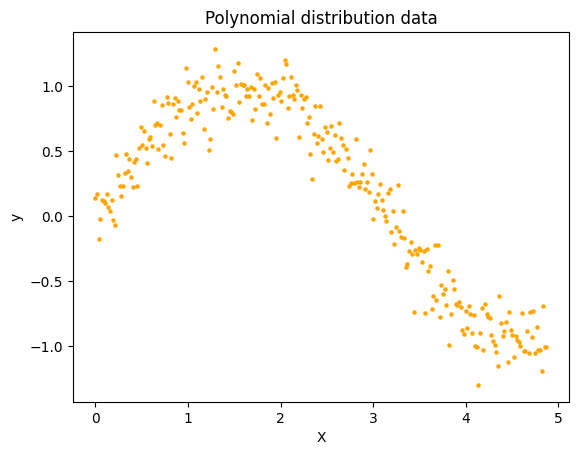

In [47]:
plt.scatter(data['x'], data['y'], c='orange', s=5)
plt.title('Polynomial distribution data')
plt.xlabel('X')
plt.ylabel('y');

As you can see, this dataset is noisy but has a clear relation between the input and the target. Let's fit a simple linear regression.

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

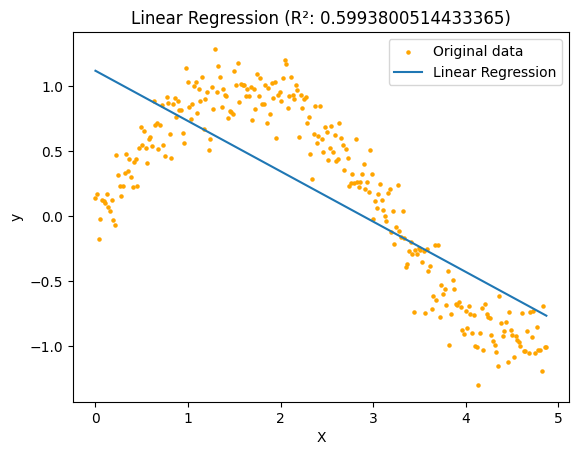

In [49]:
X = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression()
lr.fit(L2Normalizer(X), y)

plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], lr.predict(L2Normalizer(X)), label="Linear Regression")
plt.title(f'Linear Regression (R²: {lr.score(L2Normalizer(X), y)})')
plt.legend(loc="best")
plt.xlabel('X')
plt.ylabel('y');

Clearly this model is underfit.

In order to try to get a better result, let's add extra inputs: **powers of `data['x']`** (aka polynomial features).

In [50]:
from utils import expand_dataset, fit_and_plot_linear_regression

In [51]:
data = expand_dataset(original_data, 3)
data.head(5)

,x,y,x^2
0,0.000000,0.137583,0.000000
1,0.017453,0.173491,0.000305
2,0.034907,-0.173676,0.001218
3,0.052360,-0.018180,0.002742
4,0.069813,0.122635,0.004874


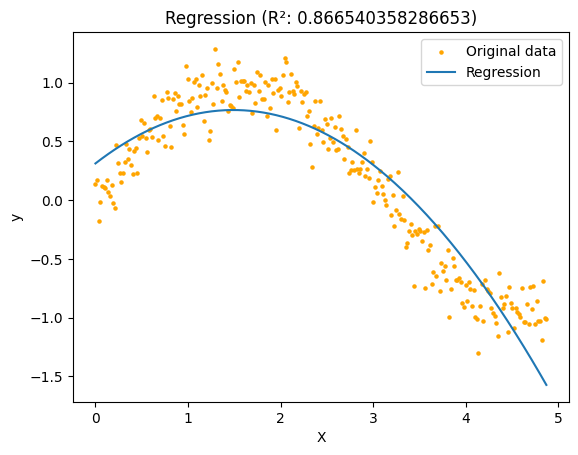

In [52]:
fit_and_plot_linear_regression(data)

We improved our $R^2$! Let's get crazy and see what happens with many more powers

In [53]:
data = expand_dataset(original_data, 10)
data.head(5)

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9
0,0.000000,0.137583,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017453,0.173491,0.000305,0.000005,9.279177e-08,1.619522e-09,2.826599e-11,4.933346e-13,8.610313e-15,1.502783e-16
2,0.034907,-0.173676,0.001218,0.000043,1.484668e-06,5.182470e-08,1.809023e-09,6.314683e-11,2.204240e-12,7.694250e-14
3,0.052360,-0.018180,0.002742,0.000144,7.516134e-06,3.935438e-07,2.060591e-08,1.078923e-09,5.649226e-11,2.957928e-12
4,0.069813,0.122635,0.004874,0.000340,2.375469e-05,1.658390e-06,1.157775e-07,8.082794e-09,5.642855e-10,3.939456e-11


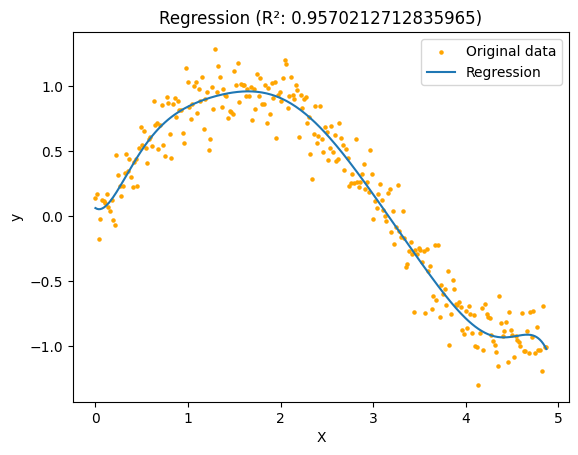

In [54]:
fit_and_plot_linear_regression(data)

Our $R^2$ is even better still!

Let's keep going with more powers!

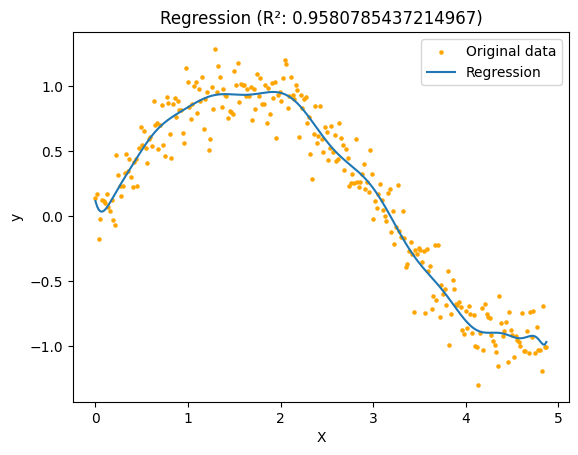

In [55]:
data = expand_dataset(original_data, 20)
fit_and_plot_linear_regression(data)

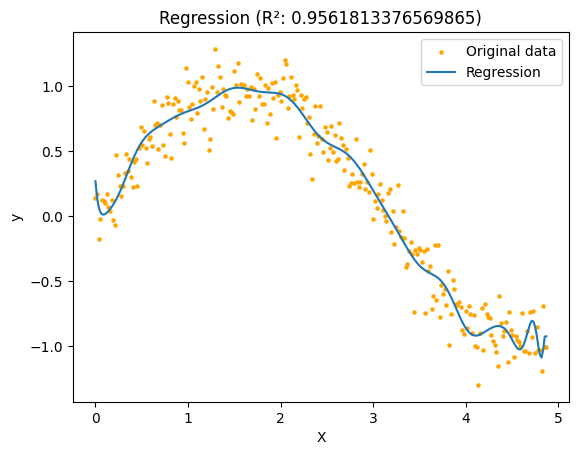

In [56]:
data = expand_dataset(original_data, 40)
fit_and_plot_linear_regression(data)

You might have noticed that the model, when adding a large number of this type of features, starts to fit to the noise as well! This means that a test set will, very likely, produce a really bad $R^2$, even though we are increasing the $R^2$ in the training set (also, remember that issue with noise fitting and $R^2$?). 

## 3.2 Ridge Regularization

One thing that we can do to address this overfitting is apply $L_2$ regularization in our linear regression model. This means changing the loss function from the standard MSE
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$
to
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \|\beta\|_2^2$$
$$=$$
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \sum_{k=1}^K \beta_k^2$$

You'll notice that the left part of the loss function, $\frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$, is still MSE. By keeping this part in the loss function, the model will continue to try to reduce this amount. If this part is low, that indicates a good fit. If it is high, that indicates a bad fit. 

However, the new part of the function, $\lambda_2 \sum_{k=1}^K \beta_k^2$, is the sum of the squares of the betas, or the coefficients. The model will also try to reduce this amount, meaning the model will award smaller coefficients. If this part is low, that indicates a simple model. If it is high, that indicates a complex model.

Ideally we will have low values for both parts, resulting in a well-fitted, simple model.

In the $L_2$ loss function, $\lambda_2$ is the strength of the regularization part, which is a parameter that can be tuned. 

As you might have noticed, $\beta_0$ (i.e. the intercept) is excluded from the regularization expression (*k* starts at 1). 

This is due to certain theoretical aspects related to the intercept that are completely out of scope in here. If you are interested in knowing more about them, check the discussion in [stats.exchange.com](https://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression) or check this **bible** called [*Elements of Statistical Learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) (there is also a MOOC for this). 

We'll go through an example using a new class that implements this type of regularization: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

In [57]:
from sklearn.linear_model import Ridge

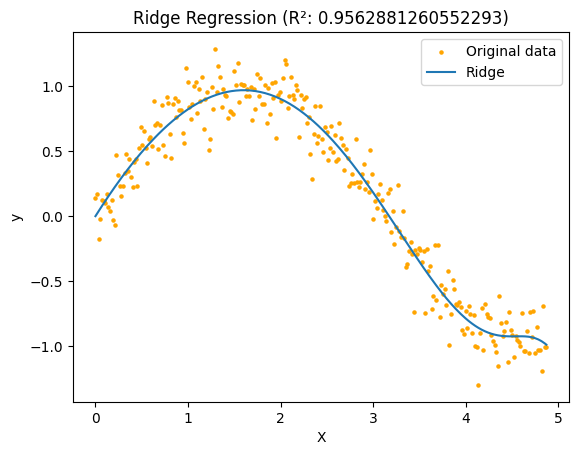

In [58]:
data = expand_dataset(original_data, 40)

X = data.drop('y', axis=1)
y = data['y']

# alpha here is the same as lambda in the loss function from above
ridge = Ridge(alpha=0.0001, random_state=10)
ridge.fit(L2Normalizer(X), y)

plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], ridge.predict(L2Normalizer(X)), label="Ridge")
plt.title(f'Ridge Regression (R²: {ridge.score(L2Normalizer(X), y)})');
plt.legend(loc="best");
plt.xlabel('X');
plt.ylabel('y');

Even though we are still allowing the model to have up to 40-degree polynomial features, the model doesn't look very overfit!

We can visualize the coefficients of the non-regularized Linear Regression and the regularized version to see what's happening:

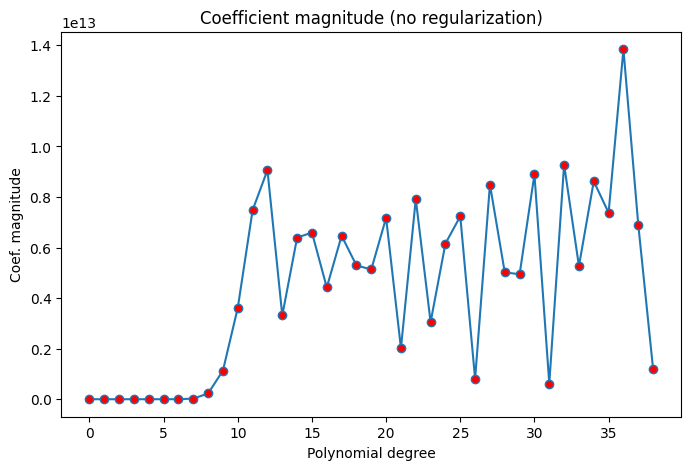

In [59]:
# No regularization
lr = LinearRegression()
lr.fit(L2Normalizer(X), y)
plt.figure(figsize = (8,5))
plt.plot(range(len(lr.coef_)), [abs(coef) for coef in lr.coef_], marker='o', markerfacecolor='r')
plt.xlabel('Polynomial degree')
plt.ylabel('Coef. magnitude');
plt.title(f'Coefficient magnitude (no regularization)');


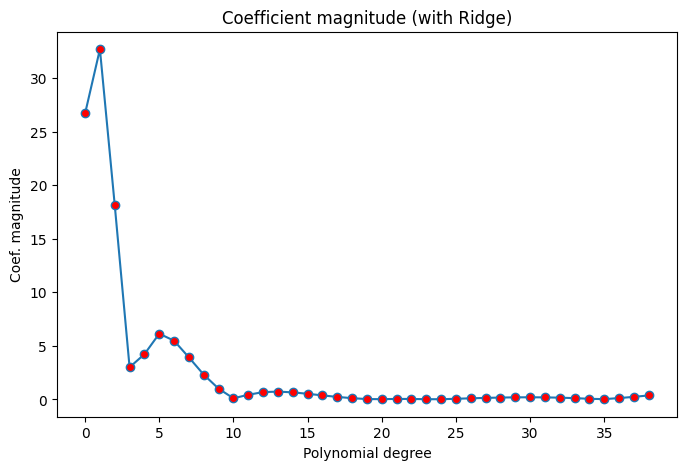

In [60]:
# With regularization
plt.figure(figsize = (8,5))
plt.plot(range(len(ridge.coef_)), [abs(coef) for coef in ridge.coef_], marker='o', markerfacecolor='r')
plt.xlabel('Polynomial degree')
plt.ylabel('Coef. magnitude');
plt.title(f'Coefficient magnitude (with Ridge)');


The Ridge model is clearly less overfit than the normal Linear Regression model, and only has 3-4 significant parameters, while the Linear Regression has 20-30!

From this, we see that another benefit of regularization can be increased **interpretability**. The regularized model automatically learns which features are important.

Let's increase the number of power features and see what happens

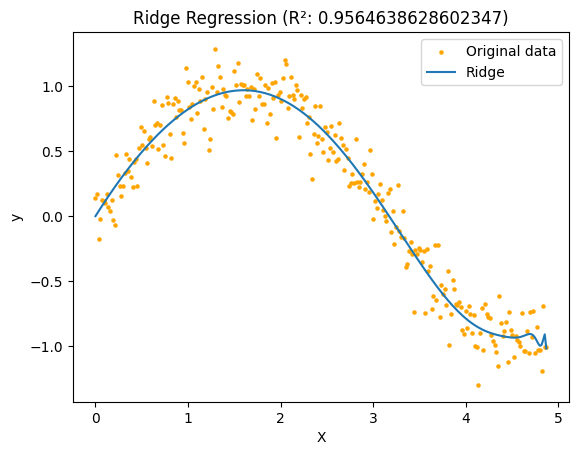

In [61]:
data = expand_dataset(original_data, 200)

X = data.drop('y', axis=1)
y = data['y']

ridge = Ridge(alpha=0.0001, random_state=10)
ridge.fit(L2Normalizer(X), y)

plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], ridge.predict(L2Normalizer(X)), label="Ridge")
plt.title(f'Ridge Regression (R²: {ridge.score(L2Normalizer(X), y)})');
plt.legend(loc="best");
plt.xlabel('X');
plt.ylabel('y');

Interesting! Even after adding more features, out model didn't change (almost) anything! 

## 3.3 Lasso Regularization

Besides $L_2$, we also have $L_1$ regularization.

The loss function for $L_1$ is


$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \|\beta\|_1^1$$
$$=$$
$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$

This is usually called [Lasso regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). The difference between lasso and ridge is that instead of squaring the coefficients in ridge, lasso uses the absolute value of the coefficients. This type of regression is way more aggressive in its approach to constraining coefficient magnitude. In many real world scenarios, it usually has just a few features with coefficients different from 0. 

Let's repeat the same examples, this time using Lasso.

In [62]:
from sklearn.linear_model import Lasso

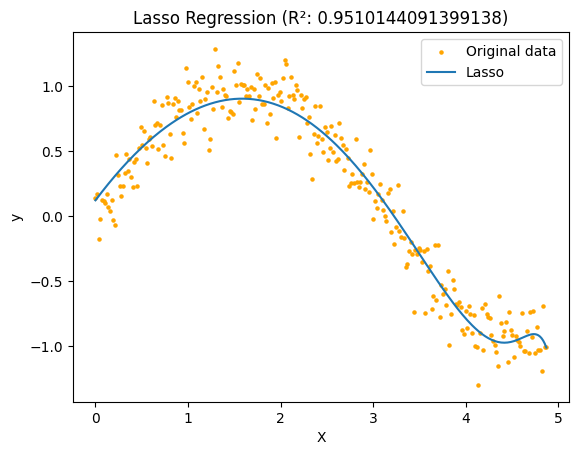

In [63]:
data = expand_dataset(original_data, 40)

X = data.drop('y', axis=1)
y = data['y']

# alpha here is the same as lambda in the loss function from above
lasso = Lasso(alpha=0.0001, random_state=10, tol=0.005)
lasso.fit(L2Normalizer(X), y)

plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], lasso.predict(L2Normalizer(X)), label="Lasso")
plt.title(f'Lasso Regression (R²: {lasso.score(L2Normalizer(X), y)})')
plt.legend(loc="best");
plt.xlabel('X')
plt.ylabel('y');

Let's visualize the coefficients of the fitted model:

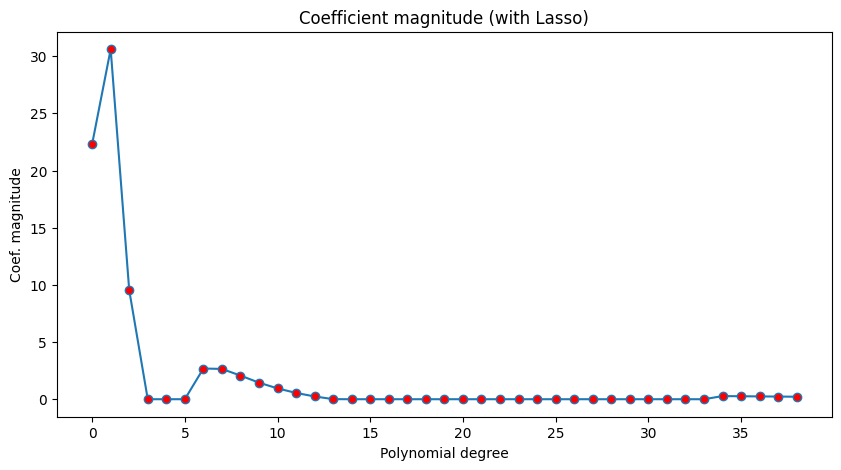

In [64]:
plt.figure(figsize = (10,5))
plt.plot(range(len(lasso.coef_)), [abs(coef) for coef in lasso.coef_], marker='o', markerfacecolor='r')
plt.xlabel('Polynomial degree')
plt.ylabel('Coef. magnitude');
plt.title(f'Coefficient magnitude (with Lasso)');


Like we saw with Ridge, just a few features (the lowest-order polynomials) are significant, and all other features are zero!

## 3.4 Elastic Net Regularization

Also, finally, we can have both $L_1$ and $L_2$ in what is called [Elastic Net regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

The loss function for elastic net just adds the extra parts we added in ridge and lasso:

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right| + \lambda_2 \sum_{k=1}^K \beta_k^2$$

We'll repeat the same example again using Elastic Net. This time `alpha` is the total weight of the penalty terms ($\lambda_1 + \lambda_2$), and we can also set the ratio of $\lambda_1$ to $\lambda_2$ with `l1_ratio`.

In [65]:
from sklearn.linear_model import ElasticNet

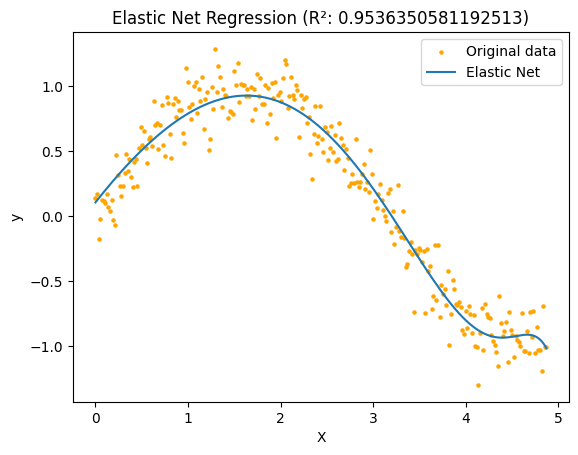

In [66]:
data = expand_dataset(original_data, 40)

X = data.drop('y', axis=1)
y = data['y']

# alpha here is the same as lambda in the loss function from above
en = ElasticNet(alpha=0.00001, l1_ratio=0.5, random_state=10, tol=0.02)
en.fit(L2Normalizer(X), y)

plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], en.predict(L2Normalizer(X)), label="Elastic Net")
plt.title(f'Elastic Net Regression (R²: {en.score(L2Normalizer(X), y)})')
plt.legend(loc="best");
plt.xlabel('X')
plt.ylabel('y');


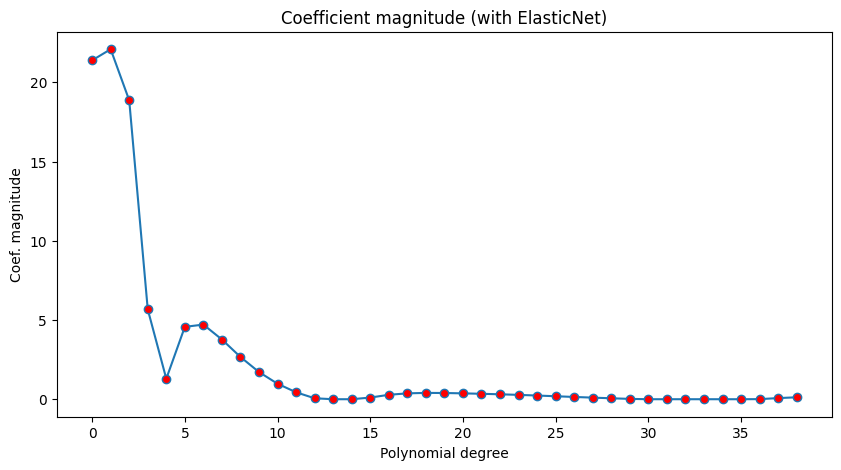

In [67]:
plt.figure(figsize = (10,5))
plt.plot(range(len(en.coef_)), [abs(coef) for coef in en.coef_], marker='o', markerfacecolor='r')
plt.xlabel('Polynomial degree')
plt.ylabel('Coef. magnitude');
plt.title(f'Coefficient magnitude (with ElasticNet)');


Again we see a similar behavior to the other regularizers!

# Part 4: Unbalanced data 

Finally, we'll talk about unbalanced data. This is a different problem: for this part we'll assume we have a nice dataset with meaningful features and just one problem: **our data is not balanced**

So what does this mean? And why do we care?

### Subtopics

1. Motivation
2. Oversampling
3. Undersampling

## 4.1 Motivation


### What is unbalanced data?

Usually when talking about unbalanced data, we are talking about classification problems where we have much more data of one class than of another one (or a set of others).  

Let's look at an example. Create a dataset with the function below:

In [68]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, 
    class_sep=1.25, 
    weights=[.85, .15], 
    n_features=10, 
    n_samples=200, 
    random_state=42
)


Plot the data points and class distribution below

<div class="alert alert-warning">Note: we are using a principal component representation of all features, roughly put this is a computation that takes all features and converts them into different components with different levels of information. We keep the top 2 most important ones and plot them. You'll learn more about this in the 4th specialization</div>

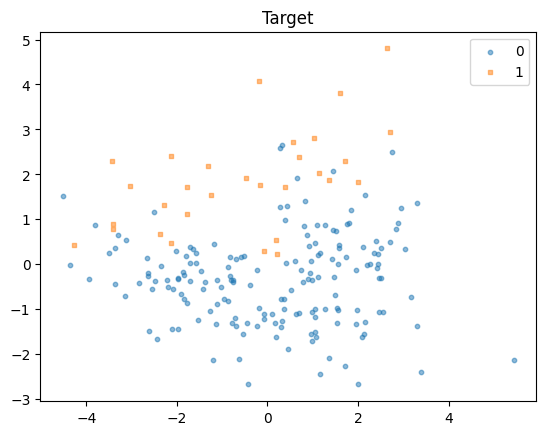

In [69]:
plot_classification(X, y)

It should be obvious that there are many more examples of class `0` than of `1`. You can confirm that by checking the `value_counts` of the classes:

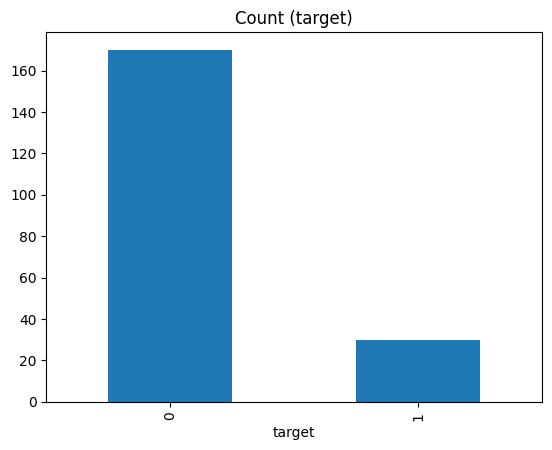

In [70]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

As you see, we've confirmed the huge discrepancy between the number of examples on one side and the other, making this data what we call **unbalanced**. 

Usually we call the class with more examples **majority class** and the one with less examples **minority class**.

### Why does it matter?

Your first thought may be - *why does it matter? Isn't more data better than less data?* - and that's natural. In general, having more data points over a problem we want to model is a good thing. However, the majority class can dominate performance, leading to poor performance over the minority class, which can happen in the form of:

* **underfitting** - eg. your classifier learned to predict always the majority class
* **overfitting** - eg. your classifier learned to predict the minority only for the very specific data points you have


Usually these problems are not only a result of the data itself, but of poor handling of it.

#### Misleading splits

The first thing we'll look at is evaluation. In the last unit you've learned how to prepare splits for validation and evaluation with sklearn. Let's see what would happen if we use the `train_test_split` to separate our data into a train-validation-test trio:

In [71]:
X_left, X_test, y_left, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_left, y_left, test_size=0.2/0.8, random_state=42
)

for y_tmp, l in zip([y_train, y_val, y_test], ["train", "validation", "test"]):
    len_y = y_tmp.size
    ones_y = y_tmp[np.where(y_tmp == 1)].size
    print(f"Size of {l}: {len_y}")
    print(f"Number of class 1 examples in {l}: {ones_y} ({np.round(100.0 * ones_y/len_y, 2)} %)")


Size of train: 120
Number of class 1 examples in train: 16 (13.33 %)
Size of validation: 40
Number of class 1 examples in validation: 6 (15.0 %)
Size of test: 40
Number of class 1 examples in test: 8 (20.0 %)


Clearly the percentages in between datasets don't match. In particular, the training set has only 13% of examples of class `1`, while the validation set has 15%, and the test set has 20% of examples of this class. This may lead to us being mislead when:

1. using the validation set to compare and choose between models
2. evaluating the test set on the data

However, sklearn offers a way of controlling this. It can split your data in a stratified way, this is, taking into account the distribution of classes and replicating it in all splits:

In [72]:
# We start by splitting the test from the dataset.
X_left, X_test, y_left, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

# Then we split the rest intro training and validation.
X_train, X_val, y_train, y_val = train_test_split(
    X_left, y_left, test_size=0.2/0.8, random_state=1234, stratify=y_left
)

for y_tmp, l in zip([y_train, y_val, y_test], ["train", "validation", "test"]):
    len_y = y_tmp.size
    ones_y = y_tmp[np.where(y_tmp == 1)].size
    print(f"Size of {l}: {len_y}")
    print(f"Number of class 1 examples in {l}: {ones_y} ({np.round(100.0 * ones_y/len_y, 2)} %)")

Size of train: 120
Number of class 1 examples in train: 18 (15.0 %)
Size of validation: 40
Number of class 1 examples in validation: 6 (15.0 %)
Size of test: 40
Number of class 1 examples in test: 6 (15.0 %)


![surprised_mike](media/surprised_mike.gif)

Amazing, right? And so simple. That tiny change ensured our data is much better prepared for model selection and evaluation.
 
#### Misleading metrics

Still in the context of evaluation, the second thing you should look at is what metrics you are using. Let's train a model and evaluate it:


In [73]:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.50%


That's great right? 

Let's look more closely to see what is happening. We'll use a confusion matrix, which will give us the number of examples in each class that were correctly identified as that class:

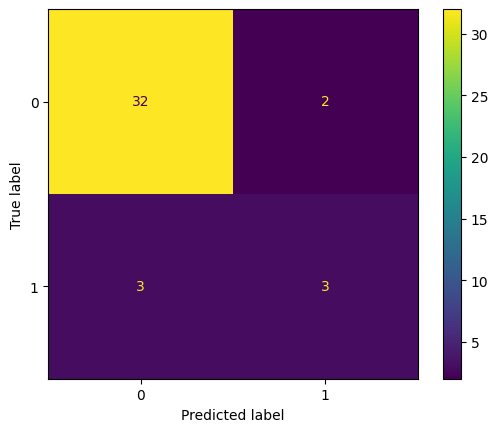

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predictions = lr_clf.predict(X_val)
cm = confusion_matrix(y_val, predictions, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_clf.classes_)
disp.plot();

If we pay a closer look to the minority class, we see that we only got right 3/6 examples, roughly 50% of the examples we have. So what is happening?

Well, as the majority class dominates the dataset and we only have one mislabeled example there, the metric reflects that.

So how do we fight this?

One of the best things you can do is make sure to look into the metric of the minority class - this one is often more important than the average metric in situations where the data is unbalanced. You can also analyze other aspects and combine metrics. From SLU10 you should remember precision-recall for example, and sklearn allows you to compute it for each class separately:


In [75]:
print("Majority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=0))
print("Rcall: %.2f" % recall_score(y_val, y_pred, pos_label=0))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=0))
print("==============")

print("Minority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=1))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=1))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=1))



Majority class
Precision: 0.91
Rcall: 0.94
F1-Score: 0.93
Minority class
Precision: 0.60
Recall: 0.50
F1-Score: 0.55


So this would be a more realistic overview of the model performance. Depending on your problem and on how much you care about different types of errors you may want to decide on a different metric for each problem.

### Resampling

We've talked about how to analyze and handle your data to avoid falling into some common traps. But we can also talk about how we can use other techniques to improve how the models learn. Most of these techniques are based on **resampling** - roughly put, these are methods that take different sets of samples from the original data samples.

We'll now drop the dummy dataset and switch to a real unbalanced dataset from insurance data. Load the data below:

In [76]:
from sklearn.preprocessing import LabelEncoder

insurance = pd.read_csv("data/insurance_data.csv").drop(columns=['id'])
insurance.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


Plot below the two classes data:

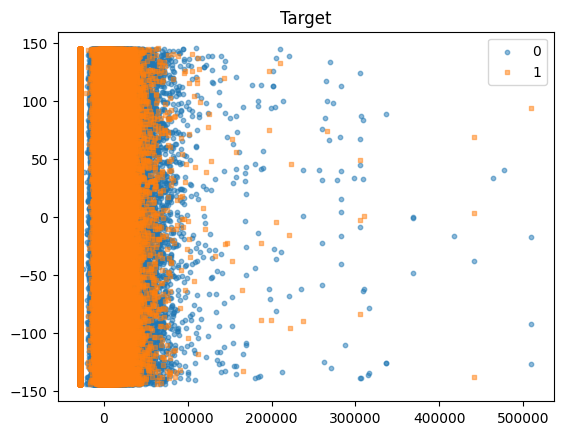

In [77]:
# We'll encode the categorical features as numeric labels to simplify the process. This may not be 
# the optimal encoding but that is not the focus of this unit.
le = LabelEncoder()
insurance.Gender = le.fit_transform(insurance.Gender)
insurance.Vehicle_Age = le.fit_transform(insurance.Vehicle_Age)
insurance.Vehicle_Damage = le.fit_transform(insurance.Vehicle_Damage)

X = insurance[[c for c in insurance.columns if c != "Response"]]
y = insurance["Response"]

plot_classification(X, y)

And then check the actual numbers on each class:

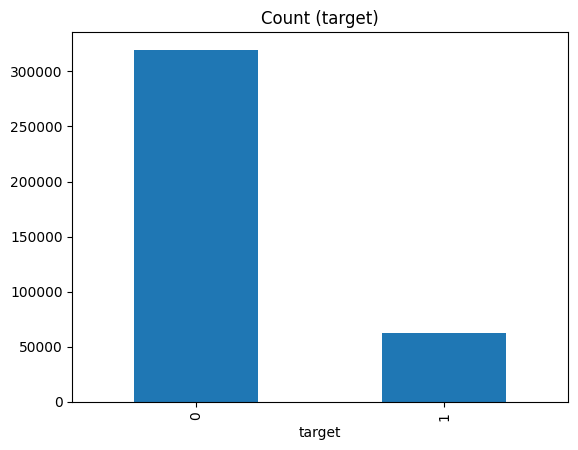

In [78]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

Before we jump into resampling methods, we'll split the data according to what we learned above:

In [79]:
X_left, X_test, y_left, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_left, y_left, test_size=0.2/0.8, random_state=1234, stratify=y_left
)

for y_tmp, l in zip([y_train, y_val, y_test], ["train", "validation", "test"]):
    y_tmp = y_tmp.values
    len_y = y_tmp.size
    ones_y = y_tmp[np.where(y_tmp == 1)].size
    print(f"Size of {l}: {len_y}")
    print(f"Number of class 1 examples in {l}: {ones_y} ({np.round(100.0 * ones_y/len_y, 2)} %)")

Size of train: 229292
Number of class 1 examples in train: 37561 (16.38 %)
Size of validation: 76431
Number of class 1 examples in validation: 12520 (16.38 %)
Size of test: 76431
Number of class 1 examples in test: 12520 (16.38 %)


Finally, we'll train a baseline `LogisticRegression` and check the confusion matrix for the validation set:

Majority class
Precision: 0.84
Rcall: 1.00
F1-Score: 0.91
Minority class
Precision: 0.47
Recall: 0.01
F1-Score: 0.02


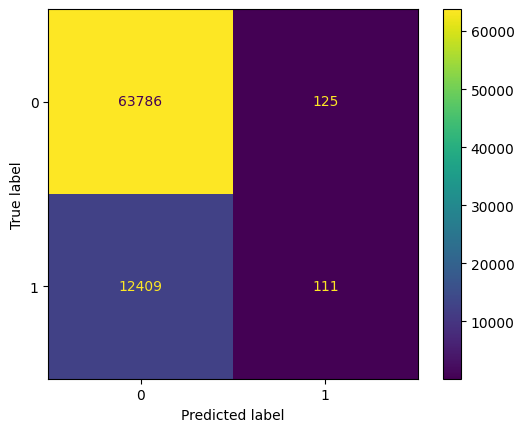

In [81]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

lr_pipeline = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_val)

print("Majority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=0))
print("Rcall: %.2f" % recall_score(y_val, y_pred, pos_label=0))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=0))
print("==============")

print("Minority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=1))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=1))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=1))

cm = confusion_matrix(y_val, y_pred, labels=lr_pipeline['logisticregression'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_pipeline['logisticregression'].classes_)
disp.plot();

Our minority class has really poor performance with the baseline. Let's see what we can do:

## 4.2 Oversampling

We'll start with oversampling, where we generally pick from existing or create samples of the minority class. A very simple strategy for this is to randomly pick samples from this class and add them to the dataset. We'll start by oversampling until we get the minority class to be 30% of the majority one.


The `imblearn` library in Python is a specialized toolkit designed to tackle imbalanced datasets. It provides a range of methods for under-sampling the majority class, over-sampling the minority class, and creating ensemble methods that balance class distribution.

### Random OverSampling

This method involves randomly duplicating instances from the minority class.

In [82]:
from imblearn.over_sampling import RandomOverSampler

ros_sampler = RandomOverSampler(sampling_strategy=.3, random_state=42)
X_over, y_over = ros_sampler.fit_resample(X_train, y_train)

If we now plot the value counts the data should be balanced: 

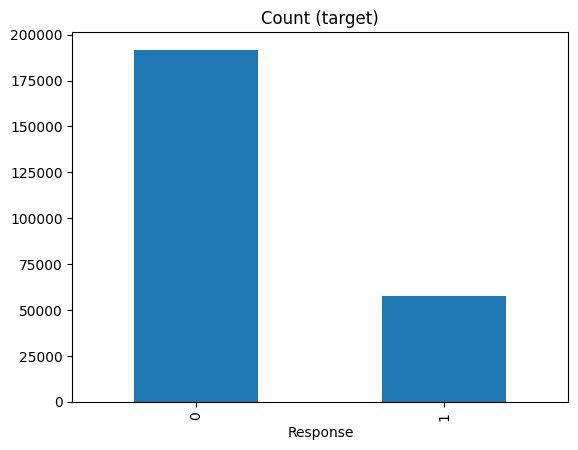

In [83]:
y_over.value_counts().plot(kind='bar', title='Count (target)');

Majority class
Precision: 0.88
Recall: 0.91
F1-Score: 0.89
Minority class
Precision: 0.43
Recall: 0.35
F1-Score: 0.38


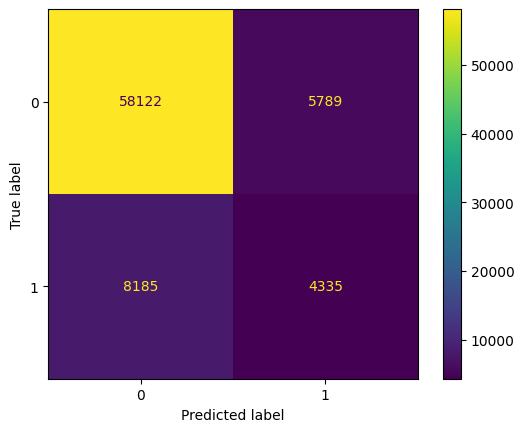

In [85]:
lr_pipeline.fit(X_over, y_over)

y_pred = lr_pipeline.predict(X_val)

print("Majority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=0))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=0))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=0))
print("==============")

print("Minority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=1))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=1))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=1))


cm = confusion_matrix(y_val, y_pred, labels=lr_pipeline['logisticregression'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_pipeline['logisticregression'].classes_)
disp.plot();

With the balanced data, we now have a slightly better performance in our validation set. Notice, however, that we sacrificed a couple of examples of the majority class. 

**Play around a bit with the ratio of the minority class and see how this trade-off evolves.**

Next we'll see another oversampling strategy - `SMOTE`. This strategy is more informed than just random sampling.

### SMOTE

SMOTE is a sophisticated algorithm that creates synthetic samples from the minority class. It works by selecting instances that are close in the feature space, drawing a line between the instances in the feature space, and drawing a new sample at a point along that line.

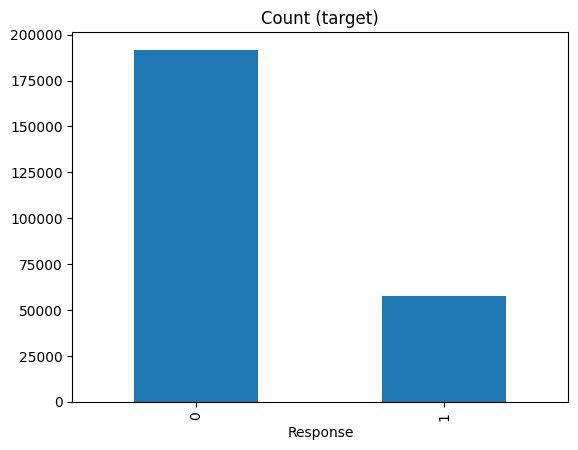

In [86]:
from imblearn.over_sampling import SMOTE

smote_sampler = SMOTE(sampling_strategy=0.3, random_state=42)
X_smote, y_smote = smote_sampler.fit_resample(X_train, y_train)

y_smote.value_counts().plot(kind='bar', title='Count (target)');

Majority class
Precision: 0.88
Recall: 0.90
F1-Score: 0.89
Minority class
Precision: 0.43
Recall: 0.38
F1-Score: 0.40


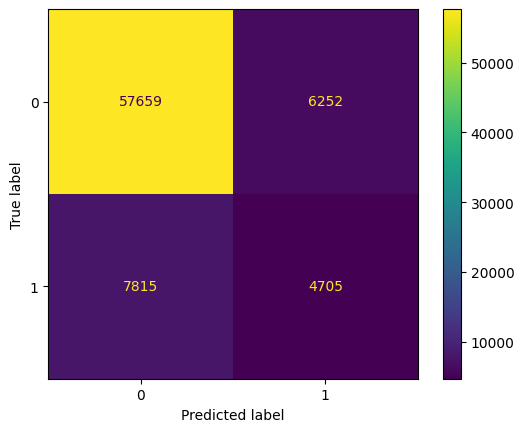

In [87]:
lr_pipeline.fit(X_smote, y_smote)
y_pred = lr_pipeline.predict(X_val)

print("Majority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=0))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=0))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=0))
print("==============")

print("Minority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=1))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=1))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=1))


cm = confusion_matrix(y_val, y_pred, labels=lr_pipeline['logisticregression'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_pipeline['logisticregression'].classes_)
disp.plot();

We get very similar results as with random sampling, with a few more examples gained on the minority class but a few more lost on the majority one. 

Once again, play around with the ratio and see how these evolve.

## 4.3 Undersampling

Next we'll look into undersampling strategies. These focus on decreasing the amount of examples of the majority class while keeping the minority untouched. Similarly to oversampling the most naïve approach is to perform this choice randomly. See below an example of random undersampling where we aim at a ratio of 50% of the majority class.

### Random UnderSampling

This method randomly eliminates samples from the majority class. While simple and straightforward, it may risk losing important information.

In [88]:
from imblearn.under_sampling import RandomUnderSampler

rus_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
X_under, y_under = rus_sampler.fit_resample(X_train, y_train)

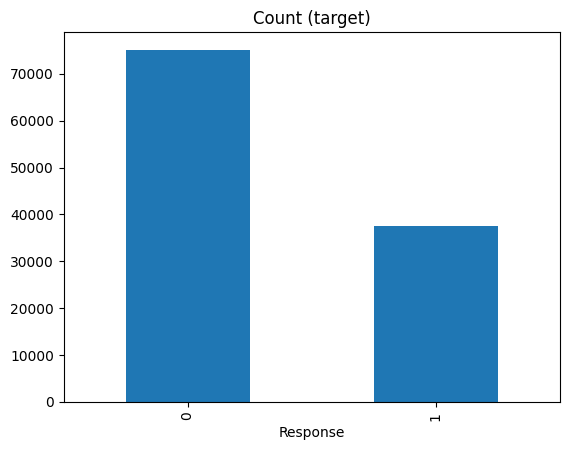

In [89]:
y_under.value_counts().plot(kind='bar', title='Count (target)');

Majority class
Precision: 0.97
Recall: 0.70
F1-Score: 0.82
Minority class
Precision: 0.37
Recall: 0.90
F1-Score: 0.53


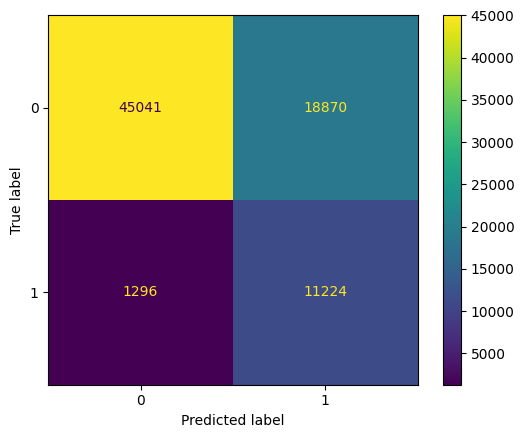

In [90]:
lr_pipeline.fit(X_under, y_under)
y_pred = lr_pipeline.predict(X_val)

print("Majority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=0))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=0))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=0))
print("==============")

print("Minority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=1))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=1))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=1))


cm = confusion_matrix(y_val, y_pred, labels=lr_pipeline['logisticregression'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_pipeline['logisticregression'].classes_)
disp.plot();


Notice how we substantially improved the minority classification, but at the cost of loosing a lot on the majority.

Finally, see the `TomekLinks` method. Unlike the previous algorithms, this method doesn't allow you to select a ratio, as it is a heuristic that focuses on pairs on the boundary between two classes. 

### TomekLinks

This method identifies Tomek Links (pairs of very close instances, but of opposite classes) and removes the majority class instances from these pairs. This helps in cleaning overlapping areas between classes.

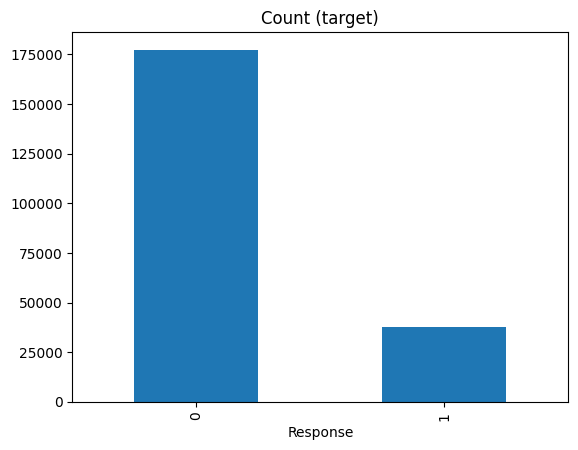

In [92]:
from imblearn.under_sampling import TomekLinks

tomek_sampler = TomekLinks()
X_tomek, y_tomek = tomek_sampler.fit_resample(X_train, y_train)
y_tomek.value_counts().plot(kind='bar', title='Count (target)');

Majority class
Precision: 0.85
Recall: 0.97
F1-Score: 0.91
Minority class
Precision: 0.48
Recall: 0.14
F1-Score: 0.22


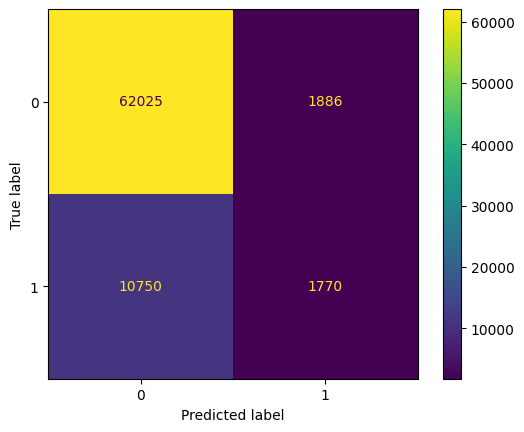

In [93]:
lr_pipeline.fit(X_tomek, y_tomek)
y_pred = lr_pipeline.predict(X_val)

print("Majority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=0))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=0))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=0))
print("==============")

print("Minority class")
print("Precision: %.2f" % precision_score(y_val, y_pred, pos_label=1))
print("Recall: %.2f" % recall_score(y_val, y_pred, pos_label=1))
print("F1-Score: %.2f" % f1_score(y_val, y_pred, pos_label=1))


cm = confusion_matrix(y_val, y_pred, labels=lr_pipeline['logisticregression'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr_pipeline['logisticregression'].classes_)
disp.plot();

The gain is much smaller, but it is still there while the loss is much smaller on the majority class. 

Obviously this is still not a great model, but you can use one or more of these methods combined and explore with your validation set which model behaves best. 


## 4.4 Final considerations

There are more methods for resampling data - whether oversampling or undersampling. You can explore the `imblearn` library if you want to learn more about those. This notebook doesn't aim at being a deep dive on sampling methods, but just a first contact with these techniques.

> ⚠️ Warning
> 
> Note we've used resampling only on the training data - we do this to avoid shifting our validation/test distributions; otherwise you may see overly-optimistic scores when there is actually no performance improvement

Finally, resampling helps when training models but it doesn't compensate for cases where the imbalance represents problems with your data gathering process. If your data is a misrepresentation of the scenario you are trying to model, resampling won't help much.

### Undersampling vs. Oversampling

It should depend on the following:

1. Amount of data you have - If you have a lot, it should be ok to undersample, but if you have very few, then oversample.
2. Importance you give to your training data - If you know there is some redundancy in the data, you should be ok with undersampling. Oversampling will always bring some information into your training data that might not be true, and can lead your model in the wrong direction.

With sufficient data, you are free to test both and see which one fits your problem best.

------

Thank you for finishing this learning notebook! Hopefully you now have a better idea of 
1. Why it's important to be selective of the features we use and avoid overly complex models, especially as a starting point  
2. Different techniques to perform feature selection, both model agnostic and model specific
3. What regularization is and how to use it in linear regression
4. How to detect and deal with unbalanced data

We provide below a bit more information about tools for feature selection, so if you're interested do take a look. And then, head off to the exercise notebook!